# Visualize Full Sky Views of GaiaDR3 and PanStarrsDR1

- You may need `astropy`, `pandas`, `pyarrow`, and `healpy`

In [29]:
# Basic Packages
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import gc

pd.options.display.max_rows = 200

# plot settings
plt.rc('font', family='serif') 
plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'

In [30]:
!pwd

/home/shong/work/example/all-sky-visualization/notebook


## Read all sky data

In [31]:
import pyarrow as pa
import pyarrow.parquet as pq

In [32]:
filepath = '/home/shong/work/example/all-sky-visualization/data/'

In [33]:
!ls $filepath

GC.fits
gaia_healpix_gal_l_b_nside1024.parquet.gzip
gaia_healpix_icrs_ra_dec_nside1024.parquet.gzip
panstar_healpix_gal_l_b_nside1024.parquet.gzip
panstar_healpix_icrs_ra_dec_nside1024.parquet.gzip


In [34]:
filenames = !ls $filepath

In [35]:
%%time
gaiadf = pd.read_parquet(filepath+filenames[1])

CPU times: user 81.1 ms, sys: 48.1 ms, total: 129 ms
Wall time: 127 ms


In [51]:
%%time
pandf = pd.read_parquet(filepath+filenames[3])

CPU times: user 79.6 ms, sys: 39.5 ms, total: 119 ms
Wall time: 118 ms


## Visualize Healpix Data

In [37]:
from matplotlib import cm
from healpy.newvisufunc import projview, newprojplot

#### Generating the line of celestial equator on Galactic Coordinate System

In [38]:
# the offset `l` is 50 degree. why? figure this out by yourself as a homework of astro101 !!!
raeq = np.arange(0,359) + 50
deceq = np.zeros(359)

In [39]:
from astropy.coordinates import SkyCoord
import astropy.units as u
def getGalacticCoordinates(inra,indec):
    tmp_eclip = SkyCoord(inra * u.deg,indec * u.deg,frame='icrs')
    tmp_gal = tmp_eclip.transform_to('galactic')
    #print("lat_theta/pi= ",lat_theta/np.pi)
    #print("lon_phi/pi= ",lon_phi/np.pi)
    
    if float(tmp_gal.l.value) < 180.0:
        return [float(tmp_gal.l.value),float(tmp_gal.b.value)]
    else:
        return [(float(tmp_gal.l.value)-360.0),float(tmp_gal.b.value)]

In [40]:
tmpline = np.array(list(map(getGalacticCoordinates,raeq,deceq)))

In [41]:
eqline = tmpline.T

In [42]:
phieqline = eqline[0] * np.pi / 180.0 
thetaeqline = (90.0 - eqline[1])* np.pi /180.0

#### Add globular clusters in our Milky Way 

In [43]:
import astropy.io.fits as fits

In [44]:
# Open the FITS file
fits_file = fits.open(filepath+filenames[0])

In [45]:
# Get the table HDU
table_hdu = fits_file[1]
# Create a Pandas DataFrame from the table data
gcdf = pd.DataFrame(table_hdu.data)

In [46]:
gcra = gcdf.RAdeg.values
gcdec = gcdf.DEdeg.values

In [47]:
gcloc = np.array(list(map(getGalacticCoordinates,gcra,gcdec))).T

In [48]:
phigc = gcloc[0] * np.pi / 180.0 
thetagc = (90.0 - gcloc[1])* np.pi /180.0
numgc = len(phigc)

## Gaia DR3

In [64]:
import warnings
warnings.filterwarnings("ignore")

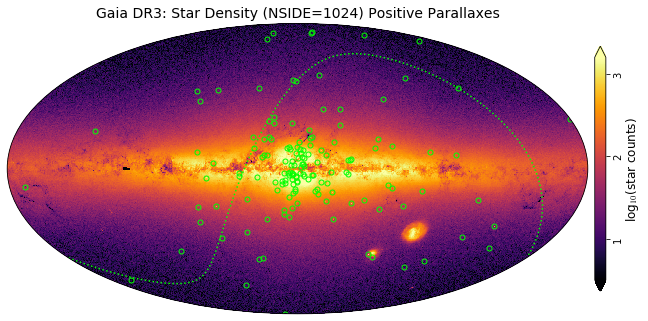

In [65]:
# classic healpy mollweide projections plot with graticule and axis labels and vertical color bar
projview(
    np.nan_to_num(np.log10(gaiadf['count'].values),nan=0,neginf=0),
    coord=["G"],
    #graticule=True,
    #graticule_labels=True,
    unit=r'log$_{10}$(star counts)',
    #xlabel="longitude",
    #ylabel="latitude",
    min=0.5,
    max=3.2,
    cbar_ticks=[1,2,3],
    cb_orientation="vertical",
    projection_type="mollweide",
    cmap=cm.inferno,
    nest=True,
    override_plot_properties={"cbar_label_pad": 1.},
    title='Gaia DR3: Star Density (NSIDE=1024) Positive Parallaxes'
)
newprojplot(thetaeqline,phieqline,linestyle='dotted', color='lime', alpha=1.0)
for i in range(numgc):
    newprojplot(theta=thetagc[i], phi=phigc[i], marker="o", \
                color="lime", markersize=5, mfc='none',alpha=1.0);
plt.savefig('gaia-dr3-galactic-nside1024.pdf')
plt.show()

## PanStarrs DR1 

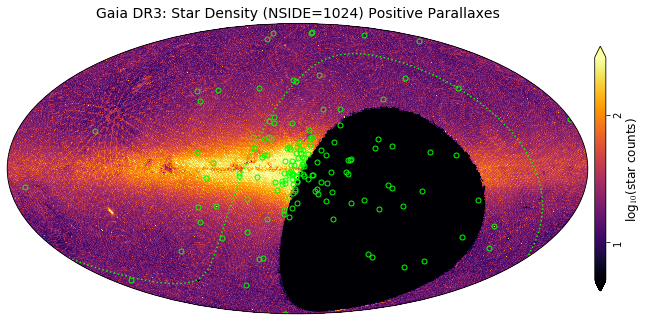

In [66]:
# classic healpy mollweide projections plot with graticule and axis labels and vertical color bar
projview(
    np.nan_to_num(np.log10(pandf['count'].values),nan=0,neginf=0),
    coord=["G"],
    #graticule=True,
    #graticule_labels=True,
    unit=r'log$_{10}$(star counts)',
    #xlabel="longitude",
    #ylabel="latitude",
    min=1.7,
    max=3.45,
    cbar_ticks=[1,2,3],
    cb_orientation="vertical",
    projection_type="mollweide",
    cmap=cm.inferno,
    nest=True,
    override_plot_properties={"cbar_label_pad": 1.},
    title='Gaia DR3: Star Density (NSIDE=1024) Positive Parallaxes'
)
newprojplot(thetaeqline,phieqline,linestyle='dotted', color='lime', alpha=1.0)
for i in range(numgc):
    newprojplot(theta=thetagc[i], phi=phigc[i], marker="o", \
                color="lime", markersize=5, mfc='none',alpha=1.0);
plt.savefig('panstarrs-dr1-galactic-nside1024.pdf')
plt.show()